In [1]:
# Plotting GAN performance

In [2]:
## Imports
import sys
import os
import time
import math
import random
import pdb

# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

import PlottingEventDisplays

In [3]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [5]:
def disp_learn_hist_smoothed(location, losslim=None, window_train=400,window_val=40,show=True):
    train_log=location+'/log_train.csv'
    val_log=location+'/log_val.csv'
    
    train_log_csv = pd.read_csv(train_log)
    val_log_csv  = pd.read_csv(val_log)

    epoch_train    = moving_average(np.array(train_log_csv.epoch),window_train)
    gloss_train = moving_average(np.array(train_log_csv.g_loss),window_train)
    dloss_train     = moving_average(np.array(train_log_csv.d_loss),window_train)
    
    epoch_val    = moving_average(np.array(val_log_csv.epoch),window_val)
    gloss_val = moving_average(np.array(val_log_csv.g_loss),window_val)
    dloss_val     = moving_average(np.array(val_log_csv.d_loss),window_val)

    epoch_val_uns    = np.array(val_log_csv.epoch)
    gloss_val_uns = np.array(val_log_csv.g_loss)
    dloss_val_uns     = np.array(val_log_csv.d_loss)
    #saved_best=np.array(val_log_csv.saved_best)
    #stored_indices=np.where(saved_best>1.0e-3)
    #epoch_val_st=epoch_val_uns[stored_indices]
    #accuracy_val_st=accuracy_val_uns[stored_indices]
    #loss_val_st=loss_val_uns[stored_indices]

    fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    line11 = ax1.plot(epoch_train, dloss_train, linewidth=2, label='Average training D loss', color='b', alpha=0.3)
    line12 = ax1.plot(epoch_val, dloss_val, label='Average validation D loss', color='blue')
    #line13 = ax1.scatter(epoch_val_st, loss_val_st, label='BEST validation loss',
                         #facecolors='none', edgecolors='blue',marker='o')
    
    ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('D Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)
   
    '''
    if losslim is not None:
        ax1.set_ylim(0.,losslim)
    else:
        ax1.set_ylim(0.,1.5)
    '''
    
    ax2 = ax1.twinx()
    line21 = ax2.plot(epoch_train, gloss_train, linewidth=2, label='Average training G loss', color='r', alpha=0.3)
    line22 = ax2.plot(epoch_val, gloss_val, label='Average validation G loss', color='red')
    #line23 = ax2.scatter(epoch_val_st, accuracy_val_st, label='BEST accuracy',
                         #facecolors='none', edgecolors='red',marker='o')
    
    
    ax2.set_ylabel('G Loss', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,1.0)
    
    # added these four lines
    #lines  = line11+ line12+ [line13]+ line21+ line22+ [line23]
    lines  = line11+ line12+ line21+ line22
    #lines_sctr=[line13,line23]
    #lines=lines_plt+lines_sctr

    labels = [l.get_label() for l in lines]
    
    leg    = ax2.legend(lines, labels, fontsize=16, loc=5, numpoints=1)
    leg_frame = leg.get_frame()
    leg_frame.set_facecolor('white')

    if show:
        plt.grid()
        plt.show()
        return

    return fig

In [6]:
def plot_log(run_ids, model_ids, model_cls, keys, dumps_path, lgd_loc=(0.8,0.5), val=False, log=False, show=False, save_path=None, mov_av=False):
    """Plot the logs for any model from saved .csv files
    
    Args:
    run_ids    -- List of run ids e.g. ["20191202_171757", ...] for each model to be plotted
    model_ids  -- Names of the models for which the log is being plotted
    model_cls  -- Two colors for each model for one axis on each size of the plot
    keys       -- Two keys for columns in the dataframe to plot (To generalize to the VAE)
    dumps_path -- Absolute path to the global dump folder
    log        -- Boolean to determine whether to use (log scaling) or not
    lgd_loc    -- Tuple to determine the location of the legend
    show       -- Boolean to determine whether to call plt.show()
    save_path  -- Absolute path of the location at which to save the plot
    """
    
    # Defensive assertions to prevent Nonetype error
    assert run_ids is not None
    assert model_ids is not None
    assert model_cls is not None
    assert dumps_path is not None
    
    # Defensive assertion to prevent breaking function usage
    assert len(run_ids) == len(model_ids)
    assert len(model_ids) == len(model_cls)
    assert len(keys) == 2
    
    # Extract the values stored in the .csv files
    train_epochs = []
    val_epochs = []
    
    train_0 = []
    train_1 = []
    
    val_0 = []
    val_1 = []
    
    dumps_path = dumps_path + "/" if not dumps_path.endswith("/") else dumps_path
    dump_dirs = [dumps_path + run_id + "/" for run_id in run_ids]
    
    # Iterate over the logs for all the models
    i = 0
    for dump_dir in dump_dirs:
        
        train_log_path = dump_dir + "log_train.csv"
        val_log_path = dump_dir + "log_val.csv"
        
        if os.path.exists(train_log_path) and os.path.exists(val_log_path):
            train_log_df = pd.read_csv(train_log_path, usecols=["epoch",keys[0],keys[1]])
            if val:
                val_log_df = pd.read_csv(val_log_path, usecols=["epoch",keys[0],keys[1]])
        
        
        train_epochs.append(train_log_df["epoch"].values)
        train_0.append(train_log_df[keys[0]].values)
        train_1.append(train_log_df[keys[1]].values)
        
        # For moving average
        if mov_av:
            train_epochs[i]    = moving_average(train_epochs[i],400)
            train_0[i] = moving_average(train_0[i],400)
            train_1[i]     = moving_average(train_1[i],400)        
        
        if val:
            val_epochs.append(val_log_df["epoch"].values)
            val_0.append(val_log_df[keys[0]].values)
            val_1.append(val_log_df[keys[1]].values)
            
            # For moving average
            if mov_av:
                val_epochs[i]    = moving_average(val_epochs[i],40)
                val_0[i] = moving_average(val_0[i],40)
                val_1[i] = moving_average(val_1[i],40)
        
        i = i + 1
     
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    for i, model_ids in enumerate(model_ids):
        if val:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], alpha=0.5, linewidth=2.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], alpha=0.5, linewidth=2.0)
            
            ax1.plot(val_epochs[i], val_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=1.0, linewidth=2.5)
            ax2.plot(val_epochs[i], val_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=1.0, linewidth=2.5)
        else:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=0.5, linewidth=2.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=0.5, linewidth=2.0)
    
    if log:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel(keys[0], fontsize=30, color=model_colors[0][0])
    ax1.tick_params(axis="y", labelsize=30, color=model_colors[0][0])
    
    ax2.set_ylabel(keys[1], fontsize=30, color=model_colors[0][1])
    ax2.tick_params(axis="y", labelsize=30, color=model_colors[0][1])
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                     fancybox=True, shadow=True, framealpha=1.0)
    
    ax1.grid(True, which="both", axis="both")
    ax2.grid(True, which="both", axis="both")
    
    plt.margins(0.2)
    
    '''
    ax1.set_ylim([0.3,1.2])
    ax2.set_ylim([0,1])
    '''
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
    if show:
        try:
            plt.show()
        except:
            print("plot_log() : Unable to render the plot due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_log() : Saving plot to ./{0}".format("vae_training_log.pdf"))
                plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
            plt.clf()
            plt.close()
    else:
        plt.clf()
        plt.close()

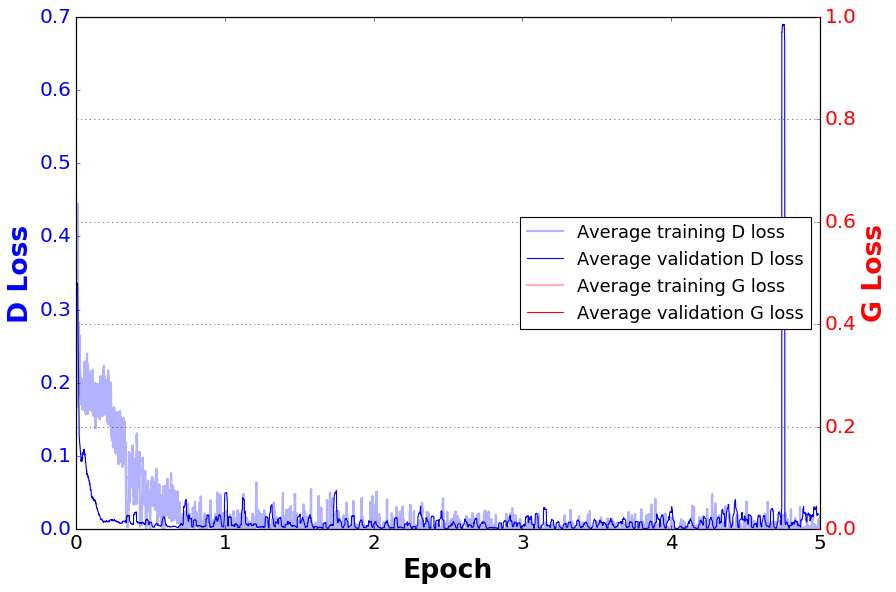

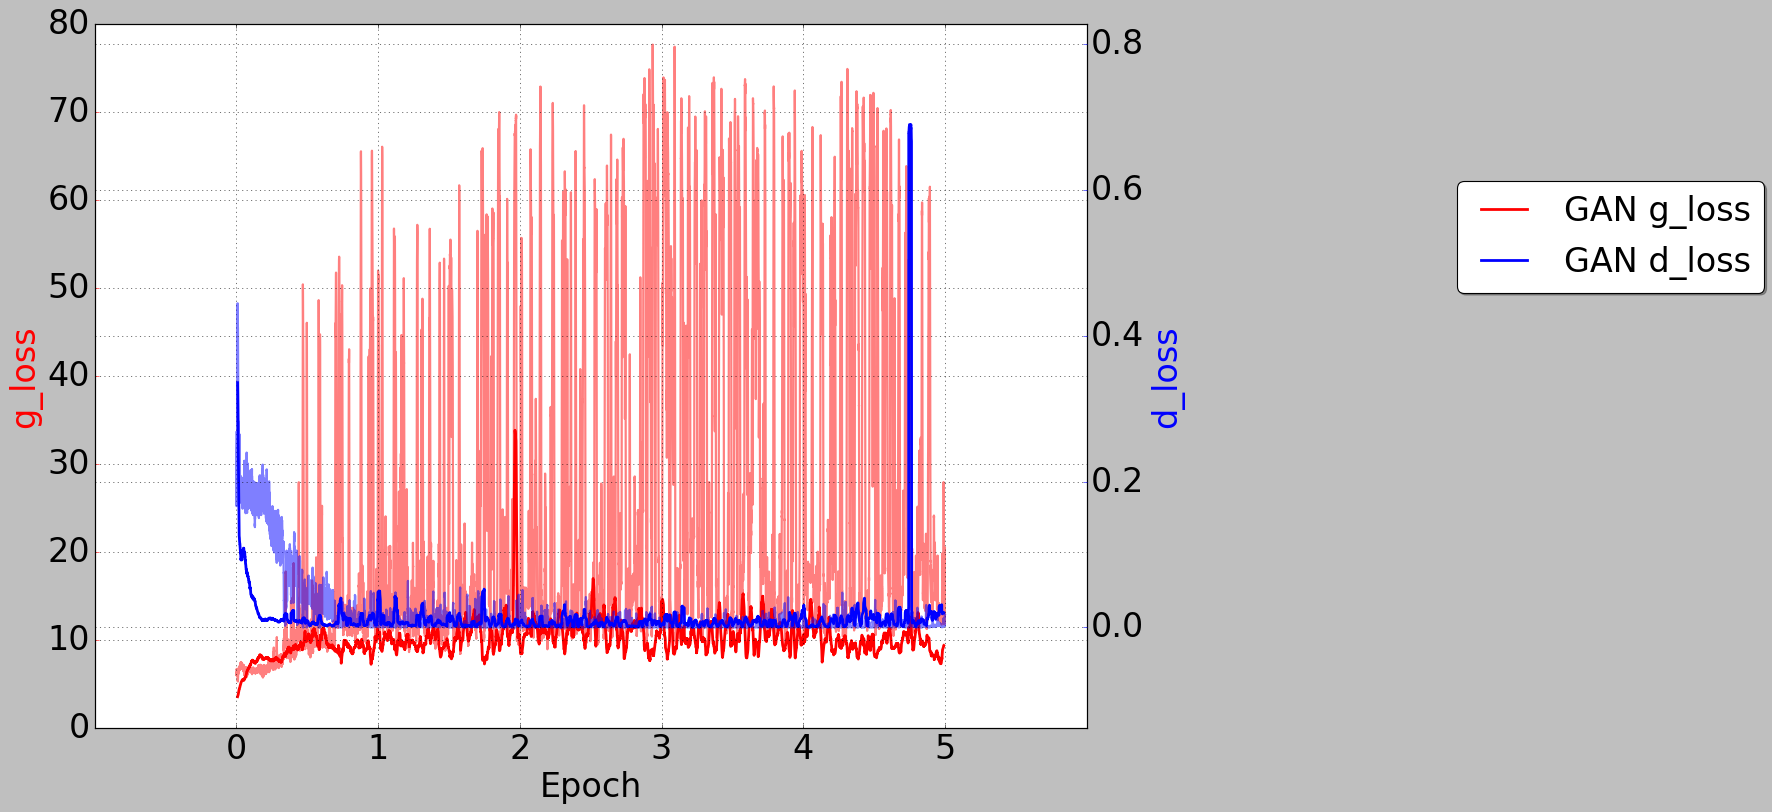

In [7]:
# Display loss vs epoch graph

loc = "/home/ttuinstr/VAE/dumps/20200427_132357"
#disp_learn_hist_smoothed(loc,window_train=200,window_val=1)
disp_learn_hist_smoothed(loc)

dumps_path = "/home/ttuinstr/VAE/dumps/"
#run_ids = [["20191202_095740"], ["20191202_095803"]]
run_ids = [["20200427_132357"]]

#model_ids = [["EresNet-18"], ["EtworesNet-18"]]
model_ids = [["GAN"]]

for run_id, model_id in zip(run_ids, model_ids):
    model_colors = [('red', 'blue') for model in model_id]
    #model_colors = [([]) for model in model_id]
    keys = ["g_loss", "d_loss"]
    plot_log(run_id, model_id, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), val=True, log=False, show=True, mov_av=True)

In [8]:
class_names = ['$\gamma$','$e$','$\mu$']

run_ids = ["20200428_134715"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path, allow_pickle=True)
    
    test_imgs  = test_dump_np['gen_imgs']
    test_gloss  = test_dump_np['g_loss'].reshape(-1)
    test_dloss = test_dump_np['d_loss'].reshape(-1)

(1, 64, 19, 40, 40)
(64, 19, 40, 40)
['events', 'labels', 'energies', 'gen_imgs', 'g_loss', 'd_loss']
(64, 40, 40, 19)
-311.2783
1094.7408


'\nimport torchvision.utils as vutils\nfrom torch import from_numpy\nimport torchvision.datasets as dset\nimport torchvision.transforms as transforms\nimport torch.utils.data\n\nimgs = vutils.make_grid(from_numpy(test_img), padding=2, normalize=True)\nfig = plt.figure(figsize=(8,8))\nplt.axis("off")\nplt.title("Generated Images")\nims = plt.imshow(np.transpose(imgs,(1,2,0)), animated=True)\n\ndataroot = "/home/ttuinstr/VAE/debugging/celeba"\nimage_size = 64\nbatch_size = 64\nworkers = 1\ndataset = dset.ImageFolder(root=dataroot,\n                                   transform=transforms.Compose([\n                                       transforms.Resize(image_size),\n                                       transforms.CenterCrop(image_size),\n                                       transforms.ToTensor(),\n                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\n                                   ])) \n\n# Create the dataloader\ndataloader = torch.utils

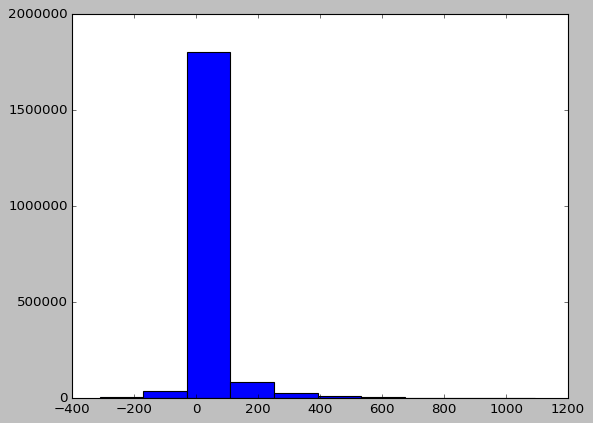

In [10]:
print(test_imgs.shape)
test_img = test_imgs[-1]
print(test_img.shape)
print(list(test_dump_np.keys()))
test_img = np.transpose(test_img, (0, 2, 3, 1))
print(test_img.shape)
#test_img = test_img + 1000
print(test_img.min())
print(test_img.max())
plt.hist(test_img[:,:,:,:].flatten())

'''
import torchvision.utils as vutils
from torch import from_numpy
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

imgs = vutils.make_grid(from_numpy(test_img), padding=2, normalize=True)
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
ims = plt.imshow(np.transpose(imgs,(1,2,0)), animated=True)

dataroot = "/home/ttuinstr/VAE/debugging/celeba"
image_size = 64
batch_size = 64
workers = 1
dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ])) 

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Plot some training images
real_batch = next(iter(dataloader))
real_img = real_batch[0].numpy()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))

#plt.hist(real_img[:,:,:,:].flatten())

print(real_img.shape)
print(real_img.min())
print(real_img.max())
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
'''

In [ ]:
# Display generated images
print(test_img.shape)

#fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
fig, ax = plt.subplots(10, figsize=(160,80), facecolor='w')
cmap = plt.cm.afmhot
cmap.set_bad(color='black')
keys = []
for i in np.arange(10):
    
    k = random.randrange (0, test_img.shape[0], 1)
    keys.append(k)
    a=PlottingEventDisplays.get_plot_array(test_img[k,:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax[i].imshow(a,
               origin="upper",
               cmap=cmap,
               norm=colors.LogNorm(vmax=np.amax(test_img[k,:,:,0:19])))
               #                               clip=True))

ax[0].set_title('Event Data, charge in mPMT',fontsize=20,fontweight='bold')

plt.show()
print(keys)

(64, 40, 40, 19)
